In [96]:
import pandas as pd
import numpy as np
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
# enable altair visualizations
alt.renderers.enable()

# opaque background
alt.themes.enable('opaque')

ThemeRegistry.enable('opaque')

In [31]:
# function to reduce size of dataframes
def downcast_df(file):
    df = pd.read_csv(file)
    
    # isolate data types
    df_int = df.select_dtypes(include=['int64'])
    df_float = df.select_dtypes(include=['float64'])
    df_obj = df.select_dtypes(include=['object'])
    
    # downcast ints and floats
    df_int = df_int.apply(pd.to_numeric, downcast='integer')
    df_float = df_float.apply(pd.to_numeric, downcast='float')
    
    # recombine into single dataframe
    optimized_df = df.copy()
    optimized_df[df_int.columns] = df_int
    optimized_df[df_float.columns] = df_float
    
    # return statement    
    return optimized_df

In [85]:
# function to print out df.info() and df.head() cleanly
def print_info(df):
    print(("=" * 10) + " Info " + ("=" * 10) + "\n")
    print(df.info())
    print("\n" + ("=" * 10) + " First 5 Rows " + ("=" * 10) + "\n")
    print(df.head())

# Products

In [86]:
products = downcast_df('products.csv')
print_info(products)

========== Info ==========

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
product_id       49688 non-null int32
product_name     49688 non-null object
aisle_id         49688 non-null int16
department_id    49688 non-null int8
dtypes: int16(1), int32(1), int8(1), object(1)
memory usage: 727.9+ KB
None

========== First 5 Rows ==========

   product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   

   department_id  
0             19  
1             13  
2              7  
3              1  
4             13  


In [54]:
orders = downcast_df('orders.csv')
print_info(orders)

========== Info ==========

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
order_id                  int32
user_id                   int32
eval_set                  object
order_number              int8
order_dow                 int8
order_hour_of_day         int8
days_since_prior_order    float32
dtypes: float32(1), int32(2), int8(3), object(1)
memory usage: 75.0+ MB
None

========== First 5 Rows ==========

   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     NaN  
1  

In [55]:
aisles = downcast_df('aisles.csv')
print_info(aisles)

========== Info ==========

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
aisle_id    134 non-null int16
aisle       134 non-null object
dtypes: int16(1), object(1)
memory usage: 1.4+ KB
None

========== First 5 Rows ==========

   aisle_id                       aisle
0         1       prepared soups salads
1         2           specialty cheeses
2         3         energy granola bars
3         4               instant foods
4         5  marinades meat preparation


In [56]:
departments = downcast_df('departments.csv')
print_info(departments)

========== Info ==========

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
department_id    21 non-null int8
department       21 non-null object
dtypes: int8(1), object(1)
memory usage: 269.0+ bytes
None

========== First 5 Rows ==========

   department_id department
0              1     frozen
1              2      other
2              3     bakery
3              4    produce
4              5    alcohol


In [57]:
prior = downcast_df('order_products__prior.csv')
print_info(prior)

========== Info ==========

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
order_id             int32
product_id           int32
add_to_cart_order    int16
reordered            int8
dtypes: int16(1), int32(2), int8(1)
memory usage: 340.3 MB
None

========== First 5 Rows ==========

   order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5          0


In [58]:
train = downcast_df('order_products__train.csv')
print_info(train)

========== Info ==========

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
order_id             1384617 non-null int32
product_id           1384617 non-null int32
add_to_cart_order    1384617 non-null int8
reordered            1384617 non-null int8
dtypes: int32(2), int8(2)
memory usage: 13.2 MB
None

========== First 5 Rows ==========

   order_id  product_id  add_to_cart_order  reordered
0         1       49302                  1          1
1         1       11109                  2          1
2         1       10246                  3          0
3         1       49683                  4          0
4         1       43633                  5          1


In [60]:
prior.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [76]:
prior['reordered'].value_counts()

1    19126536
0    13307953
Name: reordered, dtype: int64

In [77]:
prior['product_id'].value_counts()[:25]

24852    472565
13176    379450
21137    264683
21903    241921
47209    213584
47766    176815
47626    152657
16797    142951
26209    140627
27845    137905
27966    137057
22935    113426
24964    109778
45007    104823
39275    100060
49683     97315
28204     89632
5876      87746
8277      85020
40706     84255
4920      82689
30391     80392
45066     79769
42265     76896
49235     76360
Name: product_id, dtype: int64

In [73]:
from scipy.sparse import coo_matrix
p_mtx = coo_matrix((prior.order_id.values, (prior.product_id.values, prior.reordered.values)))

In [75]:
p_mtx.toarray()

array([[         0,          0],
       [1213118116, 1961331090],
       [ 132664698,   21454120],
       ...,
       [  58585694,  136430887],
       [  13632920,    9651338],
       [ 124906522,   24935543]], dtype=int32)

# Merge DFs

In [90]:
prior_merge1 = pd.merge(prior, products, on="product_id", how="left")
df = pd.merge(prior_merge1, orders, on="order_id", how="left")
df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,202279,prior,3,5,9,8.0


# Data Exploration

In [ ]:
# source = pd.DataFrame({
#     'a': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I'],
#     'b': [28, 55, 43, 91, 81, 53, 19, 87, 52]
# })

alt.Chart(orders).mark_bar().encode(
    x='a',
    y='b'
)

In [92]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
order_id                  int32
user_id                   int32
eval_set                  object
order_number              int8
order_dow                 int8
order_hour_of_day         int8
days_since_prior_order    float32
dtypes: float32(1), int32(2), int8(3), object(1)
memory usage: 75.0+ MB


In [118]:
time_of_day = orders['order_hour_of_day'].value_counts()
time_of_day = time_of_day.reset_index()
time_of_day['pct_of_total'] = np.round((time_of_day['order_hour_of_day'] / time_of_day['order_hour_of_day'].sum()*100), 2)
time_of_day.head()

,index,order_hour_of_day,pct_of_total
0,10,288418,8.43
1,11,284728,8.32
2,15,283639,8.29
3,14,283042,8.27
4,13,277999,8.13


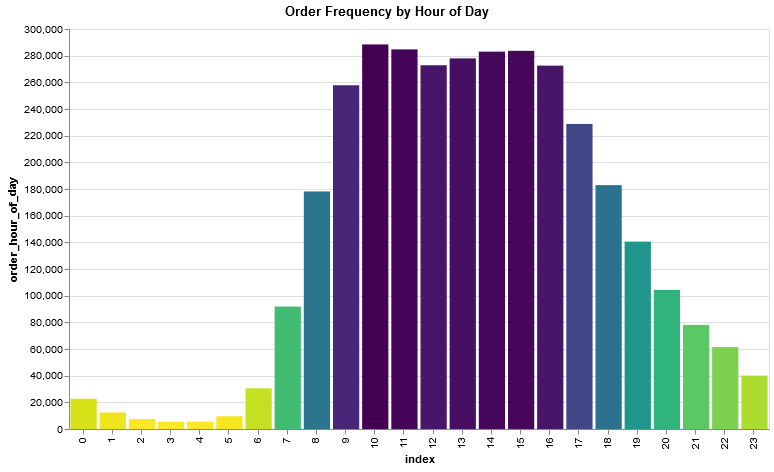

In [162]:
alt.Chart(time_of_day).mark_bar().encode(
    alt.X("index:O", bin=False),
    alt.Y('order_hour_of_day:Q'),
#     alt.ColorValue('darkorange'),
#     color = alt.Color('order_hour_of_day', alt.ColorValue("blue")),
#     color='orange',
    color = alt.Color('order_hour_of_day', legend=None, sort="descending", scale=alt.Scale(scheme='viridis')),
    tooltip=[alt.Tooltip('index:O', title="Hour of Day"), alt.Tooltip('order_hour_of_day:Q'), alt.Tooltip('pct_of_total:Q')]
    ).properties(title="Order Frequency by Hour of Day", width=700, height=400)